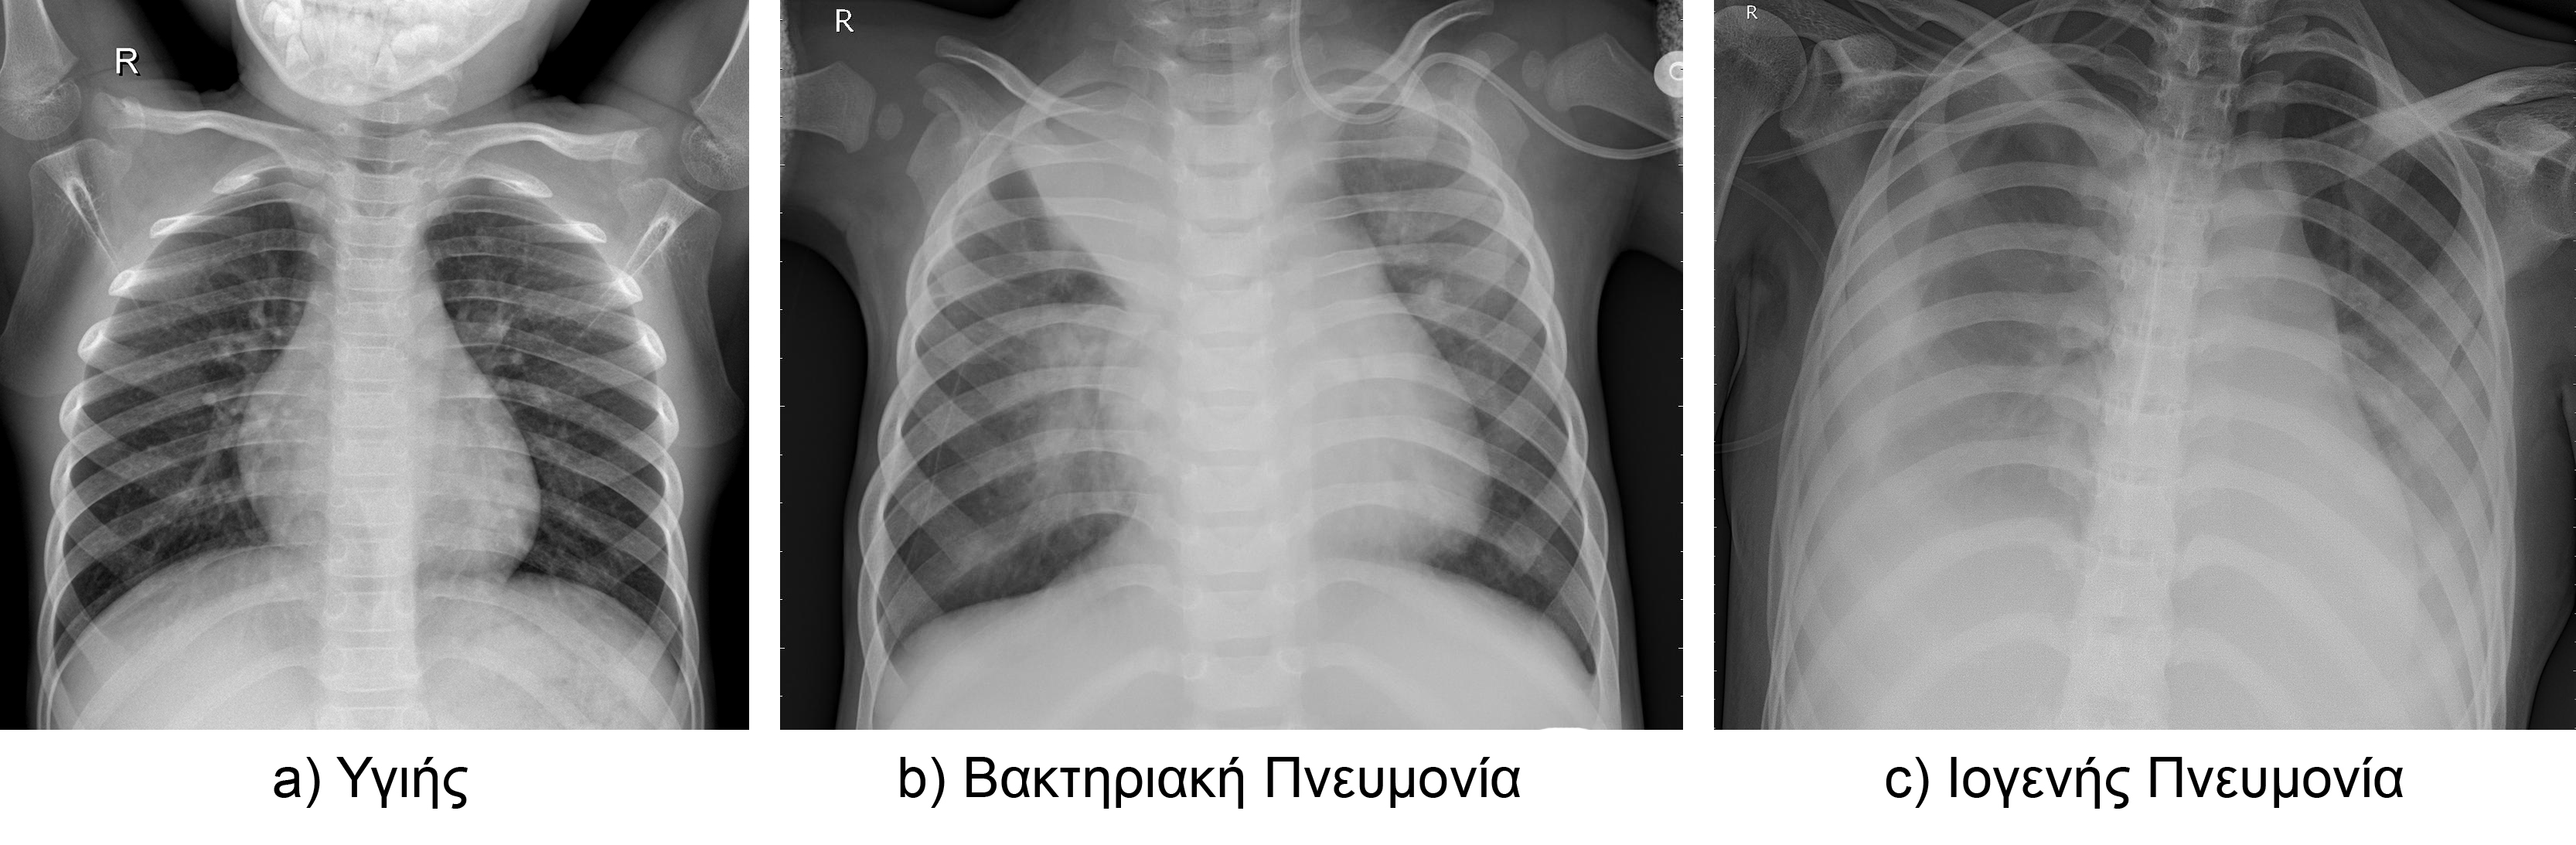

<center><h1><b>Detect Pneumonia (Fall 2020)
Detect pneumonia from bacteria or virus using chest X-ray images</b></h1>
<h2>M.Sc Web Intelligence</h2>
<h2>International Hellenic University (IHU)</h2>
<h2>[M203] - Machine Learning</h2>
<h3>Kyros Giorgos ID: 112020</h3>
<h3>Manolas Ioannis ID: 132020</h3>
</center>

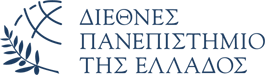



```
1. Importing Libraries
```



In [1]:
# Install all the prerequisites for efficientneB0 with @pip
!pip install efficientnet

     |████████████████████████████████| 51kB 8.8MB/s 


In [2]:
#Imported libraries and modules
import efficientnet.keras as efn
from keras.applications import DenseNet201
from sklearn.metrics import classification_report,accuracy_score,f1_score,confusion_matrix
import numpy as np
import pandas as pd 
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import os
from keras.models import Model
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.optimizers import Adam,SGD, RMSprop
from keras.applications import VGG16, ResNet50, DenseNet121, InceptionV3, DenseNet201, Xception 
from sklearn.utils import shuffle
from keras import layers
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D,MaxPool2D
from keras.layers import  GlobalAveragePooling2D, BatchNormalization

In [3]:
# Mount the drive files
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/




```
2. Set up Hyper Parameters
```



In [4]:
# Initializing all the hyperparameters
#--------------------------------------------------------------------------------------------
# The image shape from image
img_shape=224
# The image size from image
IMAGE_SIZE=(224, 224)
# The batch size for training model (values used : (2, 4, 6, 8, 16, 32, 64, 128))
# The best values were (16,32)
BATCH_SIZE=16
# The number of classes. Our problem has 3 classes (0: Normal, 1: Bacterial Pneumonia, 2: Virus)
NUM_CLASSES=3
# The number of epochs. (20)
# The best values were (10,15,20)
NUM_EPOCHS=25
# Filename of model, we use to save model weights
WEIGHTS_FINAL='model-final.h5'



```
3. Call the Pretrained Model
```



In [ ]:
# Calling VGG16 with weights from imagenet, we set include_top as False
baseModel=VGG16(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
baseModel.summary()

In [22]:
# Using here EfficientNet series BO
import efficientnet.keras as efn
# Calling serie BO from EfficientNet with weights from imagenet, we set include_top as False
baseModel=efn.EfficientNetB0(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
baseModel.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [6]:
# Freeze the already trained layers from pretrained models
for layer in baseModel.layers:
  layer.trainable = False

In [23]:
# Add flatten layer and 5 Dense layers with (128, 64, 64, 32, 16) feature maps
# Secondly we add 2 dropout with (0.1)
# Finally we add a last layer with 3 output classes and activation function softmax
x = (baseModel.output)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.1)(x)

preds = layers.Dense(3, activation = "softmax")(x)
model = tf.keras.models.Model(baseModel.input, preds)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________



```
4. Prepare the Data (Preprocessing and Data Augmentation)
```



In [24]:
# Read the labels_train.csv with pandas library and set the Data Augmentation parameters.
traindf_b=pd.read_csv("/content/drive/MyDrive/msc/ml/images/labels_train.csv",dtype=str)
data_gen= ImageDataGenerator(
    rescale=1./255,        
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    #zoom_range=0.05,
    #channel_shift_range=0.0,
    #samplewise_center=False,
    horizontal_flip=True,
    dtype="float32",
    validation_split=0.2,
    fill_mode='nearest')

# Upsample the data, copying images diff from (0,2) to be thge same number with the number of class (1)
traindf_a = traindf_b
# Sort values from traidf on value (class_id)
traindf_test=traindf_a.sort_values('class_id',ignore_index=True)
# Extract the number of rows
df0 = traindf_test.loc[0:1011]   
df2 = traindf_test.loc[3466:4500]   
#concat all the final data
frames = [traindf_a, df0, df2]
traindf = pd.concat(frames)
traindf = traindf.reset_index(drop=True)

# Shuffle the train data frame for taking random classes
traindf=shuffle(traindf)

In [25]:
# Visualise the traindf dataframe().
traindf

,file_name,class_id
5596,img_7068165703089109781.jpg,0
3012,img_8179720467024022741.jpg,1
1890,img_9101471460554341876.jpg,1
5189,img_1847187104930450858.jpg,0
3106,img_7627955520088464808.jpg,0
...,...,...
2605,img_2622755306974180958.jpg,0
3826,img_1043749395064980760.jpg,0
6196,img_803987012706415527.jpg,2
2601,img_5811556747676486751.jpg,2


In [9]:
# Read images based on dataframe applied data augmentation technique.
# -----------------------------------------------------------------------------
# @train_generator has all the images from train set in 80%.
# All images mode is on RGB (3 channels).
# Class Mode is Categorical because we have 3 classes in our problem.
train_generator = data_gen.flow_from_dataframe(
    dataframe=traindf,
    directory="/content/drive/MyDrive/msc/ml/images/train/",
    x_col="file_name",
    y_col="class_id",
    subset="training",
    color_mode="rgb",
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE
)

# @validation_generator has all the images from train set in 20%
# the same settings as train set were applied and at validation set
validation_generator = data_gen.flow_from_dataframe(
    dataframe=traindf,
    directory="/content/drive/MyDrive/msc/ml/images/train/",
    x_col="file_name",
    y_col="class_id",
    subset="validation",
    color_mode="rgb",
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE
)

Found 5376 validated image filenames belonging to 3 classes.
Found 1343 validated image filenames belonging to 3 classes.


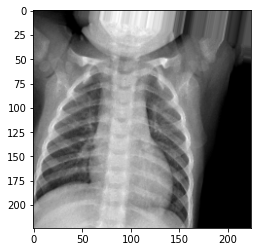

In [26]:
# Plotting raw images just for review
plt.imshow(train_generator[0][0][0])

In [27]:
# Demo code to see the equality number of all classes on 2 subsets (training,validation)
c0=0
c1=0
c2=0

for img in train_generator.labels:
  if img == 0:
    c0=c0+1;
  elif img == 1:
    c1=c1+1;
  else :
    c2=c2+1;

print("class 0 : ",c0)
print("class 1 : ",c1)
print("class 2 : ",c2)

class 0 :  1771
class 1 :  1805
class 2 :  1800


In [14]:
# @test_generator has all the images from test set in 100%
# the batch size is setting to 1 because we want to check and predict 1-1 the test images
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(    
    directory="/content/drive/MyDrive/msc/ml/images/test_images/",    
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE)

Found 1168 images belonging to 1 classes.




```
5. Fine Tuning and Compile, Fit the model
```



In [15]:
# On this part we set callbacks list with checkpoint and EarlyStopping
checkpoint = ModelCheckpoint(WEIGHTS_FINAL, monitor='val_accuracy', 
                        verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1,
                      patience=25, restore_best_weights=True)

callbacks_list = [checkpoint, early]

In [16]:
# Setting STEP_SIZE_TRAIN, STEP_SIZE_VALID, STEP_SIZE_TEST which we are used on model.fit
#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [17]:
# Compiling the model with Optimizer Adam and loss function. Finally, we want to show accuracy metrics.
# Used Options for Optimizer were =>  Optimizers : {Adam, RMSprop, Adagrad}
# Used Options for Loss Function were =>  Loss Functions : {binary_crossentropy, categorical_crossentropy}
# Learning Rate : 0.0001 (values used : {0.00001, 0.001, 0.0003})
model.compile(optimizer = Adam(lr=0.0001), loss="binary_crossentropy", metrics=['accuracy'])

In [18]:
# Fitting the model with and save the results and history in var results
results = model.fit(train_generator,
                        steps_per_epoch = train_generator.samples // BATCH_SIZE,
                        validation_data = validation_generator,
                        validation_steps = validation_generator.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        verbose=1,
                        callbacks=callbacks_list)
model.save(WEIGHTS_FINAL)

Epoch 1/25
336/336 [==============================] - 1499s 4s/step - loss: 0.4886 - accuracy: 0.6434 - val_loss: 0.3140 - val_accuracy: 0.7869

Epoch 00001: val_accuracy improved from -inf to 0.78690, saving model to model-final.h5
Epoch 2/25
336/336 [==============================] - 139s 414ms/step - loss: 0.3455 - accuracy: 0.7701 - val_loss: 0.3275 - val_accuracy: 0.7824

Epoch 00002: val_accuracy did not improve from 0.78690
Epoch 3/25
336/336 [==============================] - 138s 412ms/step - loss: 0.3310 - accuracy: 0.7858 - val_loss: 0.2864 - val_accuracy: 0.7974

Epoch 00003: val_accuracy improved from 0.78690 to 0.79744, saving model to model-final.h5
Epoch 4/25
336/336 [==============================] - 138s 412ms/step - loss: 0.3134 - accuracy: 0.8011 - val_loss: 0.2767 - val_accuracy: 0.7997

Epoch 00004: val_accuracy improved from 0.79744 to 0.79970, saving model to model-final.h5
Epoch 5/25
336/336 [==============================] - 138s 411ms/step - loss: 0.2971 - ac



```
6. Plotting charts about loss and accuracy of model
```



In [19]:
# Visualize function to visualize the diagramms of loss and accuracy
def visualize(results):

	history = results.history
	plt.figure()
	plt.plot(history['val_loss'])
	plt.plot(history['loss'])
	plt.legend(['val_loss', 'loss'])
	plt.title('Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.show()
	
	plt.figure()
	plt.plot(history['val_accuracy'])
	plt.plot(history['accuracy'])
	plt.legend(['val_accuracy', 'accuracy'])
	plt.title('Accuracy')
  
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.show()
 


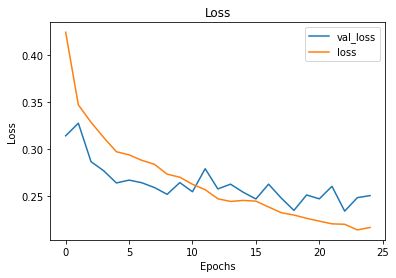

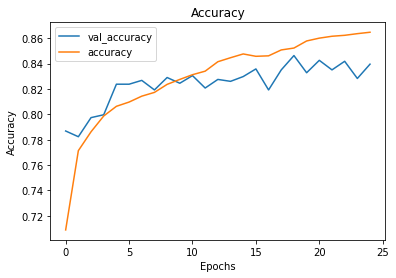

In [20]:
 visualize(results)

In [ ]:
# Plain ------------------------------------------------CNN--------------------------------------------------------
# Dont mess with this, only for first tries.
model = Sequential()
model.add(Conv2D(8 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 3 , activation = 'softmax'))
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
# confusion matrix - tested on plain cnn
cm = confusion_matrix(y_test_num,predictions)
cm = pd.DataFrame(cm , index = names , columns = names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize = (10,10))
sns.heatmap(cm,
            annot=labels,
            cmap= "coolwarm",
            linecolor = 'black',
            linewidth = 1,
            fmt='')

The following graph (confusion matrix) was produced from earlier plain CNN that we had trained. We split the dataset (70% - train | 20% - validation | 10% - test ). 

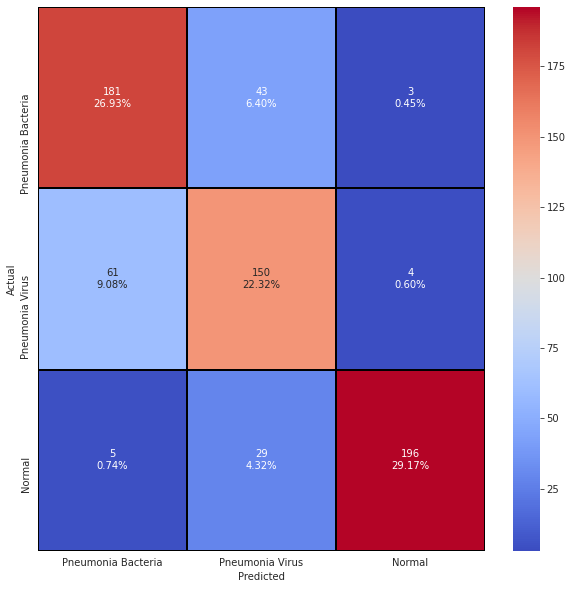



```
7. Evaluate the Model. Make predictions 
```



In [21]:
# code to make prediction on test set.
# we saved predictions on .csv datetime-format filename, and this .csv file was our submission for kaggle Competition.
from datetime import datetime
saved_model = load_model(WEIGHTS_FINAL)
file_name = datetime.now().strftime('submission_%H%M_%d%m%Y.csv')
test_generator.reset()
pred=saved_model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=list()
files_name = test_generator.filenames
for x in files_name:
  filenames.append(os.path.basename(x))
#filenames=os.path.basename(test_generator.filenames)
results=pd.DataFrame({"file_name":filenames,
                      "class_id":predictions})
results.to_csv("/content/drive/MyDrive/msc/ml/predicts/manolas/"+file_name,index=False)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1168/1168 [==============================] - 352s 300ms/step


In [ ]:
model.save('/content/drive/MyDrive/msc/ml/models/effb654.h5')